# <font style="color:blue">Table of Content</font>

- [Step 1: Understand Your Problem](#step1)
- [Step 2: Get the Data](#step2)
- [Step 3. Data Preparation](#step3)
- [Step 4: Train a Simple Model](#step4)
- [Step 5: Sample Prediction](#step5)
- [Step 6. Display Mistakes](#step6)

# <font style="color:blue">Project 1 - Part 2: Train an Image Classifier From Scratch</font>
As discussed in the previous notebook, the steps for training Neural Networks are:

- Step 1 - Understand your problem
- Step 2A - Get the data
- Step 2B - Explore and understand your data
- Step 2C - Create a sample data from the dataset
- Step 3 - Data preparation
- Step 4 - Train a simple model on sample data and check the pipeline before proceeding to train the full network
- Step 5 - Train on full data
- Step 6 - Improve your model

You have already been through Steps `1-4` in the previous notebook. Use them here as well.

Here, you will implement Steps `5` & `6` from scratch. Design a model that achieves `>=85%` validation accuracy on the given dataset.

There are 70 points for this notebook. The sections which carry marks are in Red.

There are **70 points** for this notebook. <font style="color:red">The sections which carry marks are in Red.</font>

For GPU compute you can use Kaggle Kernels, Google Colab or any other service of your choice.

After completing the assignment, upload and submit it on the portal for feedback.

<font style="color:red">Use the full data to train the network. You need to achieve 85% accuracy for validation data to successfully complete this assignment.</font>


<font style="color:red">Just remember to build your own model, not use any pre-trained models/weights.</font>


Upon completing the assignment, <font style="color:red">upload the notebook and the models folder on the portal for  feedback.</font>

# <font style="color:blue">Step 1: Understand Your problem </font><a name="step1"></a>
Already covered in the previous notebook.

# <font style="color:blue">Step 2: Get the Data </font><a name="step2"></a>

Already covered in the previous notebook.

In [109]:
# !wget "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1" -O data.zip

### <font style="color:green">Extract the Data</font>

In [110]:
# !unzip -q data.zip

# <font style="color:blue">Step 3. Data Preparation</font><a name="step3"></a>
Already covered in the previous notebook.

## <font style="color:blue">3.1. Import Libraries </font>

In [111]:
%matplotlib inline

In [112]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [113]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

### <font style="color:green">3.2.1. Compulsary Preprocessing Transforms</font>

In [114]:
def image_preprocess_transforms():

    preprocess = transforms.Compose([

            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(20, fill=(0,0,0)),
                transforms.RandomCrop(28, padding=4)
            ]),

                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.RandomErasing()
                ])

    return preprocess

### <font style="color:green">3.2.2. Common Image Transforms</font>

In [115]:
def image_common_transforms(mean=(0.4611, 0.4359, 0.3905), std=(0.2193, 0.2150, 0.2109)):
    preprocess = image_preprocess_transforms()

    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])

    return common_transforms


### <font style="color:green">3.2.3. Mean and STD</font>

In [116]:
def get_mean_std(data_root, num_workers=4):

    transform = image_preprocess_transforms()

    loader = data_loader(data_root, transform)

    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in loader:
        batch_mean += batch_data.mean(dim=(0, 2, 3)) # E[batch_i]
        batch_mean_sqrd += (batch_data ** 2).mean(dim=(0, 2, 3)) #  E[batch_i**2]

    # E[dataset] = E[E[batch_1], E[batch_2], ...]
    mean = batch_mean / len(loader)

    # var[X] = E[X**2] - E[X]**2

    # E[X**2] = E[E[batch_1**2], E[batch_2**2], ...]
    # E[X]**2 = E[E[batch_1], E[batch_2], ...] ** 2

    var = (batch_mean_sqrd / len(loader)) - (mean ** 2)

    std = var ** 0.5
    print('mean: {}, std: {}'.format(mean, std))

    return mean, std

## <font style="color:blue">3.3. Data Loaders </font>

### <font style="color:green">3.3.1. Data Loader for Full Data</font>
Data loader for generating batches of data to be used by the training routine

In [117]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)

    loader = torch.utils.data.DataLoader(dataset,
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)

    return loader

## <font style="color:green">3.4. Prepare Data</font>
The main function which uses all the above functions to generate the train and test dataloaders.


In [118]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):

    train_path = os.path.join(data_root,"training")
    test_path = os.path.join(data_root, "validation")
    mean, std = get_mean_std(data_root)

    if data_augmentation:
      tranform =  image_process_transforms()
    else:
      transform = image_common_transforms(mean, std)

    train_loader = data_loader(train_path, transform, batch_size=16, shuffle= True ,num_workers=2)
    test_loader = data_loader(test_path, transform, batch_size=16, shuffle= False ,num_workers=2)

    return train_loader, test_loader


# <font style="color:blue">Step 4: Train Your Model</font><a name="step4"></a>

Now, create the training pipeline, and train your model on the full data.

## <font style="color:red">4.1. Configurations [20 Points]</font>

To achieve good results, change the parameters given in these configurations. Score 20 points for all right choices.

### <font style="color:green">4.1.1. System Configuration</font>

Fix the seed (e.g., `21`) to get a reproducible result.

In [119]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

### <font style="color:green">4.1.2. Training Configuration</font>

In [120]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 32
    epochs_count: int = 100
    init_learning_rate: float = 0.003  # initial learning rate for lr scheduler
    log_interval: int = 5
    test_interval: int = 1
    data_root: str = "C:\\Users\\Thunder\\PycharmProjects\\model_training_cvdl\\data\cat-dog-panda\\"
    num_workers: int = 2
    device: str = 'cuda'



In [121]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

### <font style="color:green">4.1.3. System Setup</font>

In [122]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:blue">4.2. Training Function</font>

You are already familiar with the training function. No changes needed here.

In [123]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:

    # change model in training mood
    model.train()

    # to get batch loss
    batch_loss = np.array([])
    batch_loss_test = 0
    # to get batch accuracy
    batch_acc = np.array([])

    for batch_idx, (data, target) in enumerate(train_loader):

        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()

        # forward pass to the model
        output = model(data)

        # cross entropy loss
        loss = F.cross_entropy(output, target)

        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()

        batch_loss = np.append(batch_loss, [loss.item()])
        
        # print(batch_loss_test)
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()

        # accuracy
        acc = float(correct) / float(len(data))

        batch_acc = np.append(batch_acc, [acc])
    # epoch_loss_test = batch_loss_test/len(train_loader)
    # print(f"epoch_loss_test: {epoch_loss_test}")
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print(f'Epoch: {epoch_idx}/{train_config.epochs_count} \nTrain Loss: {epoch_loss:.6f} Acc: {:.4f}'.format( ,, epoch_acc))
    return epoch_loss, epoch_acc

## <font style="color:blue">4.3. Validation Function</font>

In [124]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    #
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)

        target = target.to(train_config.device)

        with torch.no_grad():
            output = model(data)

        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target).item()

        # Score to probability using softmax
        prob = F.softmax(output, dim=1)

        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]

        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)

    # average over number of dataset
    accuracy = 100. * count_corect_predictions / len(test_loader.dataset)

    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )

    return test_loss, accuracy/100.0

## <font style="color:blue">4.4. Save the Model</font>

In [125]:
def save_model(model, device, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):


    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)

    if device == 'cuda':
        model.to('cuda')

    return

## <font style="color:blue">4.5. Load the Model</font>

In [126]:
def load_model(model, model_dir='models', model_file_name='cat_dog_panda_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))

    return model

## <font style="color:blue">4.6. Main Function for Training</font>

Note: Before calling the train function, we calculate the validation loss, which we know should be close to $\log(\text{num_classes})$. Also, the accuracy should be close to $\frac{1}{\text{num_classes}}$.

In [127]:
def main(model, optimizer, scheduler=None, system_configuration=SystemConfiguration(),
         training_configuration=TrainingConfiguration(), data_augmentation=True):

    class EarlyStopping:
        def __init__(self, tolerance=5, min_delta=0):

            self.tolerance = tolerance
            self.min_delta = min_delta
            self.counter = 0
            self.early_stop = False

        def __call__(self, train_loss, validation_loss):
            if (validation_loss - train_loss) > self.min_delta:
                self.counter +=1
                if self.counter >= self.tolerance:  
                    self.early_stop = True



    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config,
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )

    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )

    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)

    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])

    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])

    # Calculate Initial Test Loss
    init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
    print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss,
                                                                                   init_val_accuracy*100))

    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):

        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)

        epoch_train_loss = np.append(epoch_train_loss, [train_loss])

        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time

        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)

            epoch_test_loss = np.append(epoch_test_loss, [current_loss])

            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])

            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        

        # scheduler step/ update learning rate
        if scheduler is not None:
            if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
                print("Bad Epochs:{}".format(scheduler.num_bad_epochs))
                print("last LR = {}".format(scheduler._last_lr))
            else:
                scheduler.step()

        # early stopping
        # earlystop = EarlyStopping(train_loss, current_loss)
        # if earlystop:
        #     print("We are at epoch:", epoch)
        #     break    

    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))

    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

## <font style="color:blue">4.7. Plot Loss and Accuracy</font>

In [128]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors,
                       loss_legend_loc='upper center', acc_legend_loc='upper left',
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):

    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()

    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])

    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))

        min_train_loss = train_loss[i].min()

        min_val_loss = val_loss[i].min()

        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID LOSS ({0:.4})".format(min_val_loss))

    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')

    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])

    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))

        max_train_acc = train_acc[i].max()

        max_val_acc = val_acc[i].max()

        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]),
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]),
                 label="VALID ACC ({0:.4})".format(max_val_acc))

    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')

    fig.savefig('sample_loss_acc_plot.png')
    plt.show()

    return

## <font style="color:red">4.8. Define Model [20 Points]</font>

Next, define the CNN model. Keep iterating. Do this by training various models. Just ,change the :
    
- number of layers
- parameters inside the layers
- different types of layers

In [129]:
class MyModel(nn.Module):
  def __init__(self, dropout=0.0, batch_norm=False):
      super().__init__()

      # convolution layers
      if batch_norm:
          self._body = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
              nn.BatchNorm2d(32),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
              
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),

              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
            

              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
              nn.Dropout(dropout),

          )
      else:
          self._body = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
              
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
              

              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
            #   nn.Dropout(dropout),

              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2),
              nn.Dropout(dropout)
         


          )


      # Fully connected layers
      self._head = nn.Sequential(

          nn.Linear(in_features=256 * 14 * 14, out_features=256),
          nn.ReLU(inplace=True),
        

          nn.Linear(in_features=256, out_features=128),
          nn.ReLU(inplace=True),
        #   nn.Dropout(dropout),

          nn.Linear(in_features=128, out_features=3),
          nn.Dropout(dropout)
      )

  def forward(self, x):
      x = self._body(x)
      x = x.view(x.size()[0], -1)
      x = self._head(x)
      return x


## <font style="color:red">4.9. Training [20 Points]</font>

Experiment with:

- Optimizers and learning rate schedulers \[You can  get good results even without a learning rate scheduler\]

- Regularization techniques like Data Augmentation, Dropout, BatchNorm

In [130]:
model = MyModel(0.3, batch_norm=True)

# get optimizer
train_config = TrainingConfiguration()

### CHANGE HERE ###

# optimizer
# optimizer = optim.Adam(
#     model.parameters(),
#     lr = train_config.init_learning_rate
# )

optimizer = optim.SGD(
    model.parameters(),
    lr = train_config.init_learning_rate,
    momentum = 0.9
    )

decay_rate = 0.5
lmbda = lambda epoch: 1/(1 + decay_rate * epoch)

scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda) 
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=decay_rate)

In [131]:
# train and validate
model, train_loss, train_acc, val_loss, val_acc = main(model, optimizer, data_augmentation=False)

mean: tensor([0.4159, 0.3928, 0.3523]), std: tensor([0.2923, 0.2810, 0.2738])

Test set: Average loss: 1.0999, Accuracy: 200/600 (33%)

Initial Test Loss : 1.099882, 
Initial Test Accuracy : 33.333%

Epoch: 0/10 
Train Loss: 1.027880 Acc: 0.4492
Elapsed 8.81s, 8.81 s/epoch, 0.06 s/batch, ets 871.76s

Test set: Average loss: 0.9263, Accuracy: 320/600 (53%)

Model Improved. Saving the Model...

Epoch: 1/10 
Train Loss: 0.954977 Acc: 0.4858
Elapsed 20.05s, 10.03 s/epoch, 0.07 s/batch, ets 982.60s

Test set: Average loss: 0.8734, Accuracy: 343/600 (57%)

Model Improved. Saving the Model...

Epoch: 2/10 
Train Loss: 0.954428 Acc: 0.4863
Elapsed 31.36s, 10.45 s/epoch, 0.07 s/batch, ets 1013.98s

Test set: Average loss: 1.1388, Accuracy: 227/600 (38%)

Epoch: 3/10 
Train Loss: 0.942839 Acc: 0.4950
Elapsed 42.38s, 10.59 s/epoch, 0.07 s/batch, ets 1017.10s

Test set: Average loss: 0.9112, Accuracy: 296/600 (49%)

Epoch: 4/10 
Train Loss: 0.894545 Acc: 0.5250
Elapsed 53.34s, 10.67 s/epoch, 0.07 

In [1]:
plot_loss_accuracy(train_loss=[train_loss],
                   val_loss=[val_loss],
                   train_acc=[train_acc],
                   val_acc=[val_acc],
                   colors=['blue'],
                   loss_legend_loc='upper center',
                   acc_legend_loc='upper left')

NameError: name 'plot_loss_accuracy' is not defined

## <font style="color:blue">4.10. Loss and Accuracy Plot</font>

# <font style="color:blue">Step 5. Sample Prediction</font><a name="step5"></a>

Show some sample predictions.

## <font style="color:blue">5.1. Make Predictions</font>

In [ ]:
def prediction(model, device, batch_input):

    data = batch_input.to(device)

    with torch.no_grad():
        output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]

    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]

    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:blue">5.2. Get Predictions on a Batch</font>

## Load Saved Model

In [ ]:
def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction
    model.eval()

    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # transformed data
    test_dataset_trans = datasets.ImageFolder(root=data_root, transform=image_common_transforms(mean, std))

    # original image dataset
    test_dataset = datasets.ImageFolder(root=data_root, transform=image_preprocess_transforms())

    data_len = test_dataset.__len__()

    interval = int(data_len/batch_size)

    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)

        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)

    inputs = torch.stack(inputs)

    cls, prob = prediction(model, device, batch_input=inputs)


    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (15, 9)
    fig = plt.figure()


    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]],
                                                        prob[i],
                                                        test_dataset.classes[targets[i]]))
    fig.savefig('sample_prediction.png')
    plt.show()

    return



## <font style="color:blue">5.3. Load Model and Run Inference</font>

mean: tensor([0.4184, 0.3963, 0.3554]), std: tensor([0.2912, 0.2806, 0.2730])


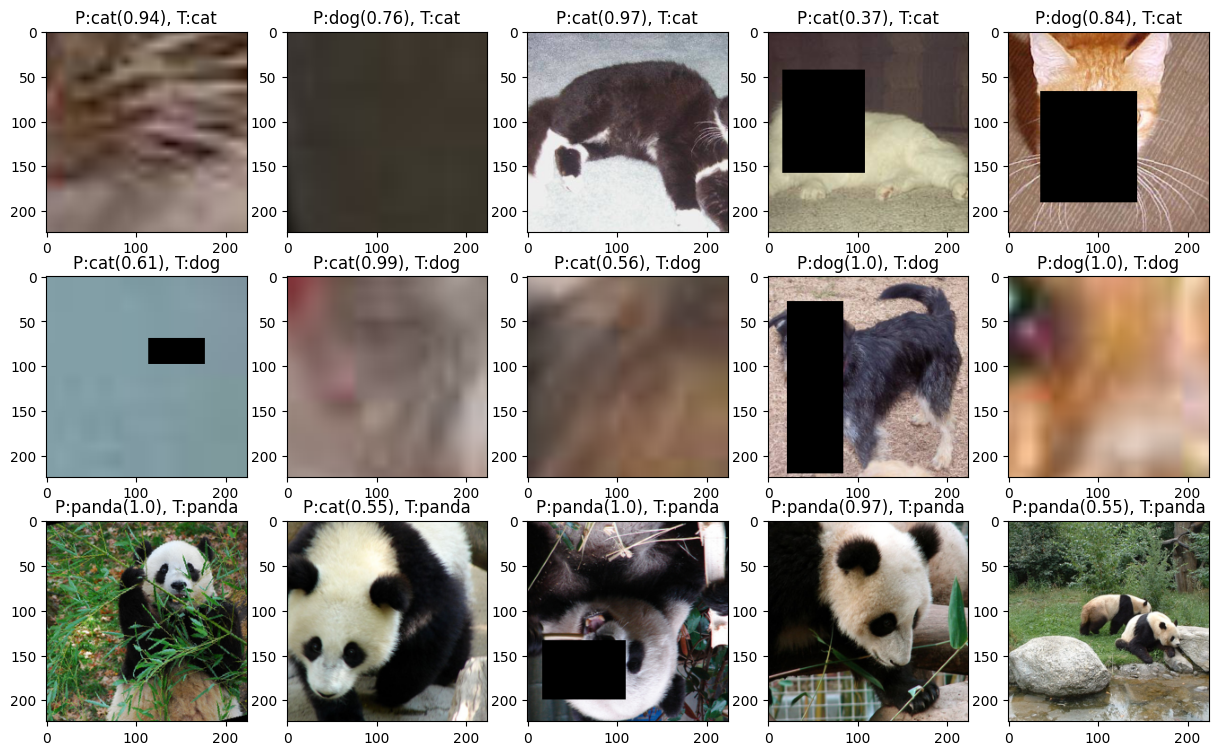

In [ ]:
model = MyModel(0.4, batch_norm=True)
model_path = 'C:\\Users\\Thunder\\PycharmProjects\\model_training_cvdl\\models\\cat_dog_panda_classifier.pt'
# loading the model and getting model parameters by using load_state_dict
model.load_state_dict(torch.load(model_path))

train_config = TrainingConfiguration()

train_data_path = os.path.join(train_config.data_root, 'training')
test_data_path = os.path.join(train_config.data_root, 'validation')

mean, std = get_mean_std(train_data_path)
# 
get_sample_prediction(model, test_data_path, mean, std)

# <font style="color:red">Step 6. Display Confusion Matrix [10 Points]</font><a name="step6"></a>

Display the confusion matrix for the above problem(Refer to the earlier lectures on Performance Metrics).


The output should resemble this:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/02/c3_w5_sample_confusion_matrix.png' width=600>


In [ ]:
def plot_confusion_matrix(model, data_root):

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2

    # It is important to do model.eval() before prediction
    model.eval()
    # Send model to cpu/cuda according to your system configuration
    model.to(device)

    # load test data
    test_loader = data_loader(data_root,transform=image_common_transforms())

    classes = ['cat', 'dog', 'panda']

    y_pred = []
    y_true = []

    # iterate over test data
    for inputs, labels in test_loader:
            
        inputs = inputs.to(train_config.device)
        labels = labels.to(train_config.device)
        with torch.no_grad():
            output = model(inputs) # Feed Network

            output = [classes[i] for i in (torch.argmax(output, 1)).data.cpu().numpy()]
            y_pred.extend(output) # Save Prediction

            labels = [classes[i] for i in labels.data.cpu().numpy()]  
            y_true.extend(labels) # Save Truth
    
    # constant for classes
    cm = confusion_matrix(y_true, y_pred,labels=classes)
    # print(cm)
    ConfusionMatrixDisplay(cm, display_labels=classes).plot()
    return

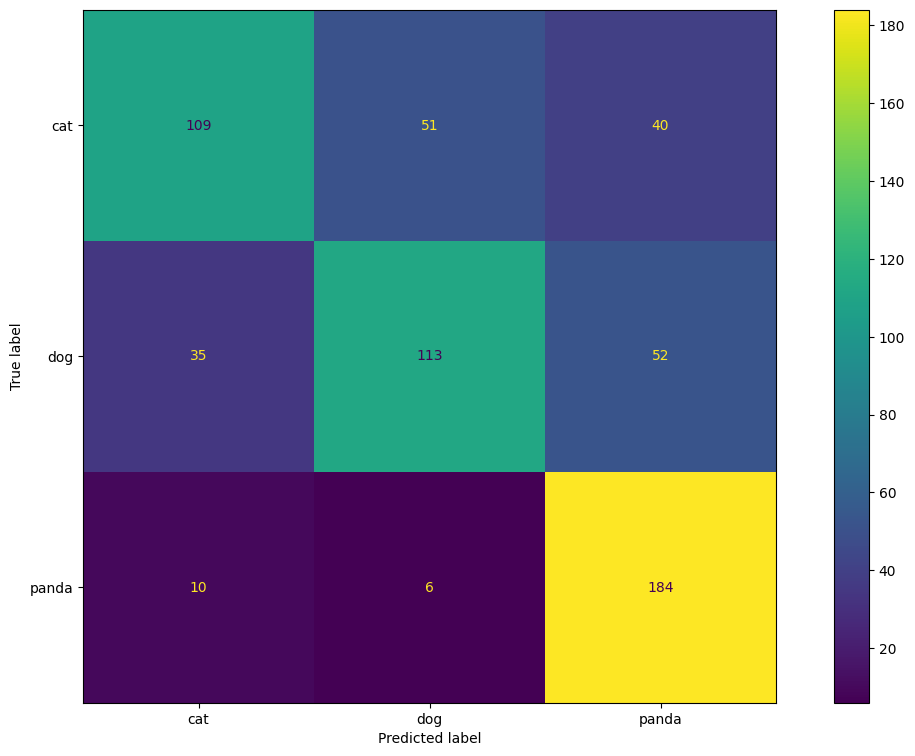

In [ ]:
model = MyModel(0.4, batch_norm=True)
# model = MyModel()
model_path = 'C:\\Users\\Thunder\\PycharmProjects\\model_training_cvdl\\models\\cat_dog_panda_classifier.pt'
# loading the model and getting model parameters by using load_state_dict
model.load_state_dict(torch.load(model_path))

train_config = TrainingConfiguration()
test_data_path = os.path.join(train_config.data_root, 'validation')

plot_confusion_matrix(model, test_data_path)

Upon completing the assignment,  <font style="color:red">pload the 2 notebooks and the models folder on the portal for feedback.</font>